# Inverse certificates

This notebook demonstrates the inverse version of our invariance-aware certificates,  
which we use in Figs. 2, 3, 4, 8, 9, 10, 11.

The inverse certificates yield the smallest prediction probability such that robustness  
can still be certified, given certain parameters of an adversarial perturbation.

We first consider adversarial scaling and then have a look at arbitrary perturbations.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

## Adversarial scaling

The first setting we considered when evaluating the inverse certificates was adversarial scaling,  
i.e. the clean input $X$ being multiplied by a scalar $c$ such that $||c \cdot X - X|| = ||\Delta||$
for some fixed $||\Delta||$.


### Example
In the following example, we take a digit $X$ from MNIST (represented as a 2D point cloud) and scale it such that $||c \cdot X - X|| = 4$.

In [2]:
from pointcloud_invariance_smoothing.evaluation.eval_forward_certs import generate_parallel_perturbation

From Jan 1, 2023, ndim will require a Sigma license to run.

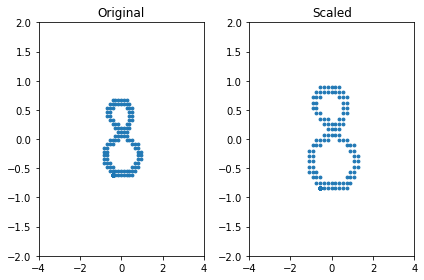

In [3]:
mnist_eight = np.load('./data/mnist_eight.npy')

plt.subplot(121)
plt.scatter(mnist_eight[:, 1], mnist_eight[:, 0], s=8)
plt.xlim(-4, 4)
plt.ylim(-2, 2)
plt.title('Original')

scaled_mnist_eight = generate_parallel_perturbation(mnist_eight, norm_delta=4)

plt.subplot(122)
plt.scatter(scaled_mnist_eight[:, 1], scaled_mnist_eight[:, 0], s=8)
plt.xlim(-4, 4)
plt.ylim(-2, 2)
plt.title('Scaled')

plt.tight_layout()

In [4]:
delta = np.linalg.norm(scaled_mnist_eight - mnist_eight)
print(f'The difference between the scaled and original point cloud has norm {delta}.')

The difference between the scaled and original point cloud has norm 4.0.


### Experiment
Next, we reproduce the experiment from Fig. 2, in which we compare the ability of the orbit-based  
and the provably tight certificate for rotation invariance to certify robustness to such scaling attacks.  
(To reduce the runtime, we evaluate on a coarser grid of perturbation norms).

As discussed in the paper, the tight certificate in 2D depends on parameters
$X$, $\Delta$ and $\epsilon_1$, $\epsilon_2$ with $\epsilon_1 = \langle X, \Delta \rangle$ $\epsilon_2 = \langle X R(-\pi/2)^T, \Delta \rangle$.

Adversarial scaling corresponds to 
$\epsilon_1 = ||X|| \cdot ||\Delta||$, $\epsilon_2 = 0$.

In [5]:
from pointcloud_invariance_smoothing.certificates.rotation_2d import inverse_2d_rotation_cert
from pointcloud_invariance_smoothing.certificates.blackbox import inverse_cert_cohen

In [6]:
sigma = 0.5  # Smoothing standard deviation
n_samples_clean = 10000  # Samples to use for finding classification threshold (see Algorithm 1)
n_samples_pert = 10000  # Samples to use to bound perturbed prediction probability (see Algorithm 1)
alpha = 0.01  # Significance level

delta_norms = np.linspace(0, 1.5, 10)
clean_norms = [0.5, 0.25, 0.1, 0.01]

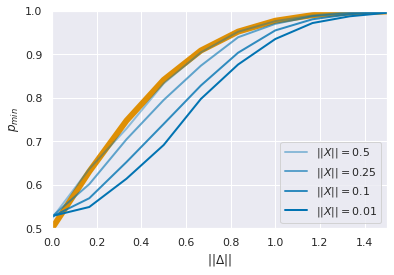

In [7]:
# Orbit-based certificate, which is identical to the black-box certificate
# when considering adversarial scaling

inverse_certs_orbit = [inverse_cert_cohen(sigma, delta) for delta in delta_norms]

sns.set_theme()
pal = sns.color_palette('colorblind', 2)
plt.plot(delta_norms, inverse_certs_orbit, color=pal[1], linewidth=6)

# Evaluate tight certificate for different clean norms
for i, clean_norm in enumerate(clean_norms):

    inverse_certs_tight = [
        inverse_2d_rotation_cert(
            sigma, clean_norm, delta,
            clean_norm * delta,  # eps_1
            0,  # eps_2
            n_samples_clean, n_samples_pert, alpha)
        for delta in delta_norms
    ]

    plt.plot(delta_norms, inverse_certs_tight, color=pal[0],
              label=f'$||X||={clean_norm}$', alpha=(0.4 + i * 0.2), linewidth=2)

plt.xlim(0, 1.5),
plt.ylim(0.5, 1)
plt.xlabel('$||\Delta||$')
plt.ylabel('$p_{min}$')
plt.legend()

We see that the tight certificate (blue) can offer much stronger guarantees than the orbit-based certificate (orange),  
if the norm of the data is small compared to the smoothing standard deviation.

## Arbitrary perturbations

Next, we consider arbitrary perturbations, for which $\epsilon_1$ and $\epsilon_2$ can take on different values.  
In the following, we reproduce a result from Fig. 4, i.e. fixing $||X||$ and $||\Delta||$ and evaluating $\epsilon_1$ and $\epsilon_2$ on a regular grid.
(To reduce the runtime, we evaluate on a coarser grid).

In [8]:
from pointcloud_invariance_smoothing.evaluation.eval_inverse_certs import eval_multiple_inner_cross

In [9]:
sigma = 0.5  # Smoothing standard deviation
n_samples_clean = 10000  # Samples to use for finding classification threshold (see Algorithm 1)
n_samples_pert = 10000  # Samples to use to bound perturbed prediction probability (see Algorithm 1)
alpha = 0.01  # Significance level

clean_norm = 0.5
delta_norm = 0.5

resolution = 20  # Number of different values of eps_1 and eps_2 to evaluate
inner_vals = np.linspace(- clean_norm * delta_norm, clean_norm * delta_norm, resolution)  # eps_1
cross_vals = np.linspace(- clean_norm * delta_norm, clean_norm * delta_norm, resolution)  # eps_2

Via the following function call we evaluate the inverse certificate on the Cartesian product
of the the different $\epsilon_1$ and $\epsilon_2$ values.  
The function also returns a 2D array indicating which combinations are actually feasible,
given $||X||$ and $||\Delta||$ (see Appendix J.1).

In [10]:
inverse_certs_tight, valid_eps_mask = eval_multiple_inner_cross(
                                            sigma, clean_norm, delta_norm,
                                            inner_vals, cross_vals,
                                            n_samples_clean, n_samples_pert, alpha)

Next, we evaluate the black-box certificate, so that we can show the difference in certificate strength.

In [11]:
inverse_cert_blackbox = inverse_cert_cohen(sigma, delta_norm)

inverse_cert_differences = inverse_cert_blackbox - inverse_certs_tight

/tmp/ipykernel_2296281/3730228328.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(im, label='$d(p_{min})$')


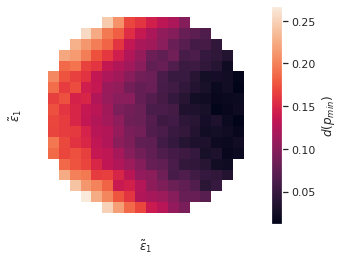

In [12]:
# Visualize as heatmap

inverse_cert_differences[~valid_eps_mask] = np.nan  # Mask out unfeasible combinations

ax = plt.subplot(111)
cmap = sns.color_palette('rocket', as_cmap=True).copy()
cmap.set_bad('white')
    
ax.grid(False)
im = ax.imshow(inverse_cert_differences.T,
            cmap=cmap,
            origin='lower')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('$\\tilde{\epsilon}_1$')
ax.set_ylabel('$\\tilde{\epsilon}_1$')

plt.colorbar(im, label='$d(p_{min})$')

We see that the tight certificate offers stronger guarantees for various choices of $\epsilon_1$ and $\epsilon_2$,
not just those corresopnding to adversarial rotation.